<a href="https://colab.research.google.com/github/SPARK10-SCA/Car-Damage-Detetion-Detectron2/blob/main/AiHub_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataDir='./drive/MyDrive/input/ai_hub_car_damage/val'
dataType='part_val'
mul_dataType='part_val'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "./drive/MyDrive/input/ai_hub_car_damage/img"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
# display categories and supercategories

#Multi Class #Parts dataset

mul_cats = coco.loadCats(coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))

""" "supercategory" : "part" 등록하는 곳 의미 없어 보여서 뺐음
mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))
"""

COCO categories for parts: 
Front bumper, Rear bumper, Front fender(R), Front fender(L), Rear fender(R), Trunk lid, Bonnet, Rear fender(L), Rear door(R), Head lights(R), Head lights(L), Front Wheel(R), Front door(R), Side mirror(R), etc



' "supercategory" : "part" 등록하는 곳 의미 없어 보여서 뺐음\nmul_nms = set([mul_cat[\'supercategory\'] for mul_cat in mul_cats])\nprint(\'COCO supercategories for parts: \n{}\n\'.format(\', \'.join(mul_nms)))\n'

In [ ]:
# get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['Front bumper']);
print(catIds)
imgIds = coco.getImgIds(catIds=catIds );
print(imgIds)

[1]
[8, 10, 4]


In [ ]:
random_img_id = random.choice(imgIds)
print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

8 image id was selected at random from the [8, 10, 4] list


In [ ]:
# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

Image details 
 {'id': 8, 'width': 800, 'height': 600, 'file_name': '0000633_sc-134388.jpg'}


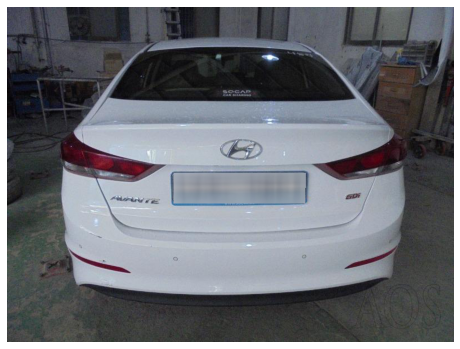

In [ ]:
I = io.imread(img_dir + '/' + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)

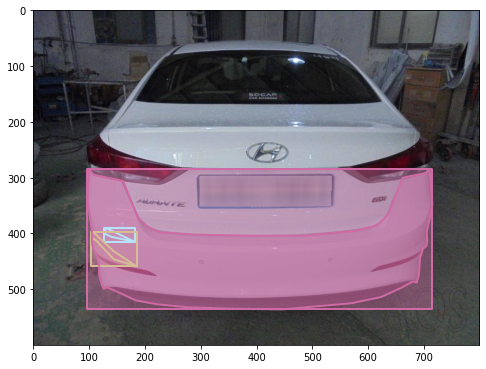

In [ ]:
#Plot damages
plt.imshow(I)
plt.axis('on')
coco.showAnns(anns, draw_bbox=True )

Training Object detection model using Detectron2

In [ ]:

#!pip uninstall torch
#!pip unistall torchvision
#!pip install torch==1.7.0 torchvision==0.8.1 torchaudio==0.7.0
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())


1.7.0 True


In [ ]:
#import torch, torchvision
#print(torch.__version__, torch.cuda.is_available())

In [ ]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
     |████████████████████████████████| 6.1 MB 590 kB/s 
     |████████████████████████████████| 151 kB 48.9 MB/s 
     |████████████████████████████████| 130 kB 70.6 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 843 kB 70.8 MB/s 
     |████████████████████████████████| 117 kB 74.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221122-py3-none-any.whl size=61484 sha256=68e92578820bebeba87639ff95610cda2554ae03de3f4dc1ad807dad55352b44
  Stored in directory: /root/.cache/pip/wheels/2d/e4/d7/be0b4010933f5fffea6385e9b319eac9d6e56c82ee4a0164e5
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=83a87254bbfa530a0f5

In [ ]:
!python -m detectron2.utils.collect_env

----------------------  ---------------------------------------------------------
sys.platform            linux
Python                  3.7.15 (default, Oct 12 2022, 19:14:55) [GCC 7.5.0]
numpy                   1.21.6
detectron2              0.5 @/usr/local/lib/python3.7/dist-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.2
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.0 @/usr/local/lib/python3.7/dist-packages/torch
PyTorch debug build     True
GPU available           Yes
GPU 0                   Tesla T4 (arch=7.5)
CUDA_HOME               /usr/local/cuda
Pillow                  7.1.2
torchvision             0.8.1 @/usr/local/lib/python3.7/dist-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5
fvcore                  0.1.5.post20221122
iopath                  0.1.8
cv2                     4.6.0
----------------------  ----------------------------------------

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [ ]:
dataset_dir = "./drive/MyDrive/input/ai_hub_car_damage"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"
test_dri = "test/"

In [ ]:
from detectron2.data.datasets import register_coco_instances
traindataset = "car_dataset_train"
valdataset = "car_dataset_val"

DatasetCatalog.clear()
MetadataCatalog.remove(traindataset)
MetadataCatalog.remove(valdataset)
register_coco_instances("car_dataset_train", {}, os.path.join(dataset_dir,train_dir,"part_train.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"part_val.json"), os.path.join(dataset_dir,img_dir))

In [ ]:
dataset_dicts = DatasetCatalog.get("car_dataset_train")
metadata_dicts = MetadataCatalog.get("car_dataset_train")

[11/23 03:50:11 d2.data.datasets.coco]: Loading ./drive/MyDrive/input/ai_hub_car_damage/train/part_train.json takes 1.68 seconds.
WARNING [11/23 03:50:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/23 03:50:11 d2.data.datasets.coco]: Loaded 80 images in COCO format from ./drive/MyDrive/input/ai_hub_car_damage/train/part_train.json


In [ ]:
#Implementing my own Trainer Module here to use the COCO validation evaluation during training
# TODO: add data custom augmentation 
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dataset_train",)
cfg.DATASETS.TEST = ("car_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 800
cfg.SOLVER.MAX_ITER = 1600 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (600, 1550)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this  dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 16  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 16 # only has one class (damage) + 1
cfg.TEST.EVAL_PERIOD = 600



# Clear any logs from previous runs
#TODO add timestamp to logs
!rm -rf cfg.OUTPUT_DIR


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/23 03:50:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:25, 6.85MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[11/23 03:50:54 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/masks.py:363: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.7/dist-packages/detectron2/structures/masks.py:363: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.7/dist-packages/detectron2/structures/masks.py:363: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python

[11/23 03:51:13 d2.utils.events]:  eta: 0:22:06  iter: 19  total_loss: 5.302  loss_cls: 2.71  loss_box_reg: 0.5806  loss_mask: 0.6929  loss_rpn_cls: 1.275  loss_rpn_loc: 0.1045  time: 0.8446  data_time: 0.1208  lr: 2.1638e-06  max_mem: 4437M
[11/23 03:51:30 d2.utils.events]:  eta: 0:23:19  iter: 39  total_loss: 5.123  loss_cls: 2.658  loss_box_reg: 0.5885  loss_mask: 0.6923  loss_rpn_cls: 1.048  loss_rpn_loc: 0.1018  time: 0.8647  data_time: 0.0190  lr: 3.3888e-06  max_mem: 4437M
[11/23 03:51:48 d2.utils.events]:  eta: 0:23:01  iter: 59  total_loss: 4.673  loss_cls: 2.582  loss_box_reg: 0.5309  loss_mask: 0.6924  loss_rpn_cls: 0.925  loss_rpn_loc: 0.09236  time: 0.8686  data_time: 0.0144  lr: 4.6137e-06  max_mem: 4812M
[11/23 03:52:06 d2.utils.events]:  eta: 0:22:50  iter: 79  total_loss: 4.547  loss_cls: 2.442  loss_box_reg: 0.5418  loss_mask: 0.6916  loss_rpn_cls: 0.7301  loss_rpn_loc: 0.08149  time: 0.8800  data_time: 0.0169  lr: 5.8388e-06  max_mem: 4812M
[11/23 03:52:25 d2.utils.e

In [ ]:
def smooth(scalars, weight=0.6):
    """
    Reference: https://github.com/plotly/dash-live-model-training/blob/master/app.py#L163
    """
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


def plot(logdir: str, savedir: str, smoothing: float = 0.6, no_title=False, no_legend=False, no_axis_labels=False):
    """ re-draw the tf summary events plots  using seaborn
    :param logdir: Path to the directory having event logs
    :param savedir: Path to save the seaborn graphs
    :param smoothing: smoothing window space for the plots
    """
    assert 0 <= smoothing <= 1, 'Smoothing value should be in [0,1]'
    
    plots = []
    
    sns.set(style="darkgrid")
    sns.set_context("paper")

    # Collect data
    # we recognize all files which have tfevents
    scalars_info = {}
    for root, dirs, files in os.walk(logdir):
        for event_file in [x for x in files if 'tfevents' in x]:
            event_path = os.path.join(root, event_file)

            acc = ea.EventAccumulator(event_path)
            acc.Reload()

            # only support scalar now
            scalar_list = acc.Tags()['scalars']
            for tag in scalar_list:
              
                x = [s.step for s in acc.Scalars(tag)]
                y = [s.value for s in acc.Scalars(tag)]
                data = {'x': x, 'y': y, 'legend': root.split(logdir)[1][1:] if root != logdir else None}
                if tag not in scalars_info:
                    scalars_info[tag] = [data]
                else:
                    scalars_info[tag].append(data)

    # We recognize groups assuming each group name has /
    # And, each group is saved in a separate directory
    for tag, tag_data in scalars_info.items():
        _split = tag.split('/')
        if len(_split) <= 1:
            _path = os.path.join(savedir, 'seaborn')
            _name = _split[0]
        else:
            _path = os.path.join(savedir, 'seaborn', _split[0])
            _name = ''.join(_split[1:])

        os.makedirs(_path, exist_ok=True)

        color_list = list(sns.color_palette(palette='dark', n_colors=len(tag_data)))[::-1]
        for data in tag_data:
            x, y = data['x'], data['y']
            y_smooth = smooth(y, weight=smoothing)
            current_color = color_list.pop()
            _plt = sns.lineplot(x, y, color=colors.to_rgba(current_color, alpha=0.4))
            _legend = data['legend'] if not no_legend else None
            _plt = sns.lineplot(x, y_smooth, label=data['legend'], color=current_color)

        if not no_axis_labels:
            _plt.set(xlabel='x', ylabel='y')
        if not no_title:
            _plt.set_title(_name.capitalize())
        
        plots.append(os.path.join(_path, _name + '.png'))
        plt.savefig(os.path.join(_path, _name + '.png'))
        plt.clf()
    return plots

In [ ]:
plots = plot(logdir= './output', savedir= './')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

<Figure size 1152x648 with 0 Axes>

In [ ]:
plots

['./seaborn/rpn/num_pos_anchors.png',
 './seaborn/rpn/num_neg_anchors.png',
 './seaborn/roi_head/num_fg_samples.png',
 './seaborn/roi_head/num_bg_samples.png',
 './seaborn/fast_rcnn/cls_accuracy.png',
 './seaborn/fast_rcnn/fg_cls_accuracy.png',
 './seaborn/fast_rcnn/false_negative.png',
 './seaborn/mask_rcnn/accuracy.png',
 './seaborn/mask_rcnn/false_positive.png',
 './seaborn/mask_rcnn/false_negative.png',
 './seaborn/data_time.png',
 './seaborn/total_loss.png',
 './seaborn/loss_cls.png',
 './seaborn/loss_box_reg.png',
 './seaborn/loss_mask.png',
 './seaborn/loss_rpn_cls.png',
 './seaborn/loss_rpn_loc.png',
 './seaborn/lr.png',
 './seaborn/time.png',
 './seaborn/eta_seconds.png',
 './seaborn/bbox/AP.png',
 './seaborn/bbox/AP50.png',
 './seaborn/bbox/AP75.png',
 './seaborn/bbox/APs.png',
 './seaborn/bbox/APm.png',
 './seaborn/bbox/APl.png',
 './seaborn/bbox/AP-Undefined.png',
 './seaborn/bbox/AP-Front bumper.png',
 './seaborn/bbox/AP-Rear bumper.png',
 './seaborn/bbox/AP-Front fender(R

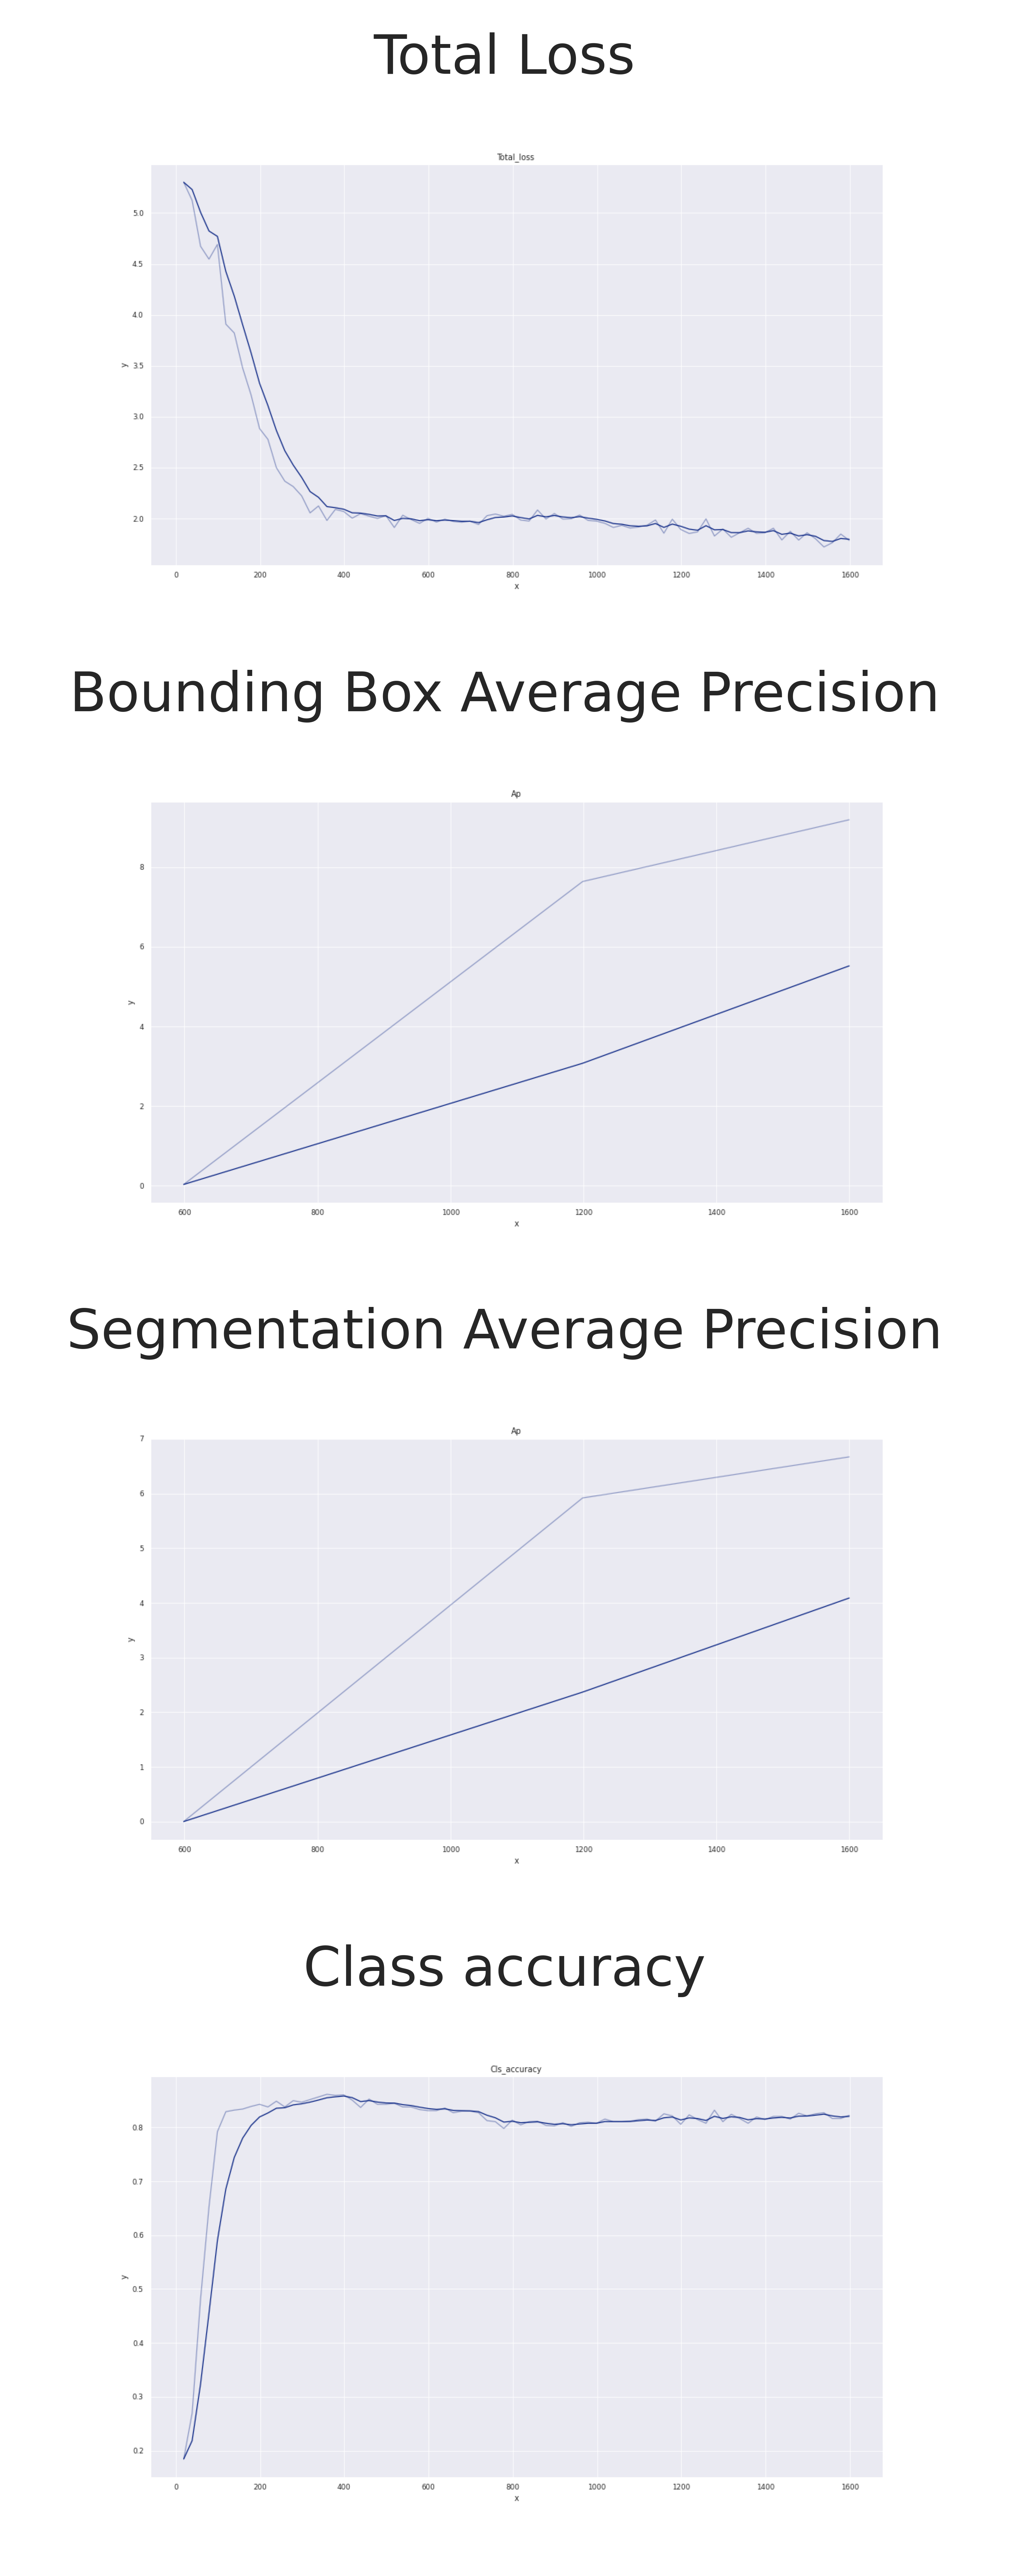

In [ ]:
my_dpi = 1000
fig, ax = plt.subplots(4,1, figsize = (12,10), dpi=my_dpi)


ax[0].set_title('Total Loss', fontsize=12)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(Image.open('./seaborn/total_loss.png'))

ax[1].set_title('Bounding Box Average Precision', fontsize=12)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(Image.open('./seaborn/bbox/AP.png'))

ax[2].set_title('Segmentation Average Precision', fontsize=12)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].imshow(Image.open('./seaborn/segm/AP.png'))

ax[3].set_title('Class accuracy', fontsize=12)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].imshow(Image.open('./seaborn/fast_rcnn/cls_accuracy.png'))

In [ ]:
evaluator = COCOEvaluator("car_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car_dataset_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [11/23 04:18:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/23 04:18:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/23 04:18:40 d2.data.datasets.coco]: Loaded 10 images in COCO format from ./drive/MyDrive/input/ai_hub_car_damage/val/part_val.json
[11/23 04:18:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/23 04:18:40 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[11/23 04:18:40 d2.data.common]: Serialized dataset takes 0.01 MiB
[11/23 04:18:40 d2.evaluation.evaluator]: Start inference on 10 batches
[11/23 04:18:43 d2.evaluation.evaluator]: Total inference time: 0:00:01.523287 (0.304657 s / iter per device, on 1 devices)
[11/23 04:1

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("car_dataset_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
val_dataset_dicts = DatasetCatalog.get("car_dataset_val")
val_metadata_dicts = MetadataCatalog.get("car_dataset_val")

WARNING [11/23 04:44:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/23 04:44:29 d2.data.datasets.coco]: Loaded 10 images in COCO format from ./drive/MyDrive/input/ai_hub_car_damage/val/part_val.json


[]
[14, 14]
[14, 14]
[14, 14]


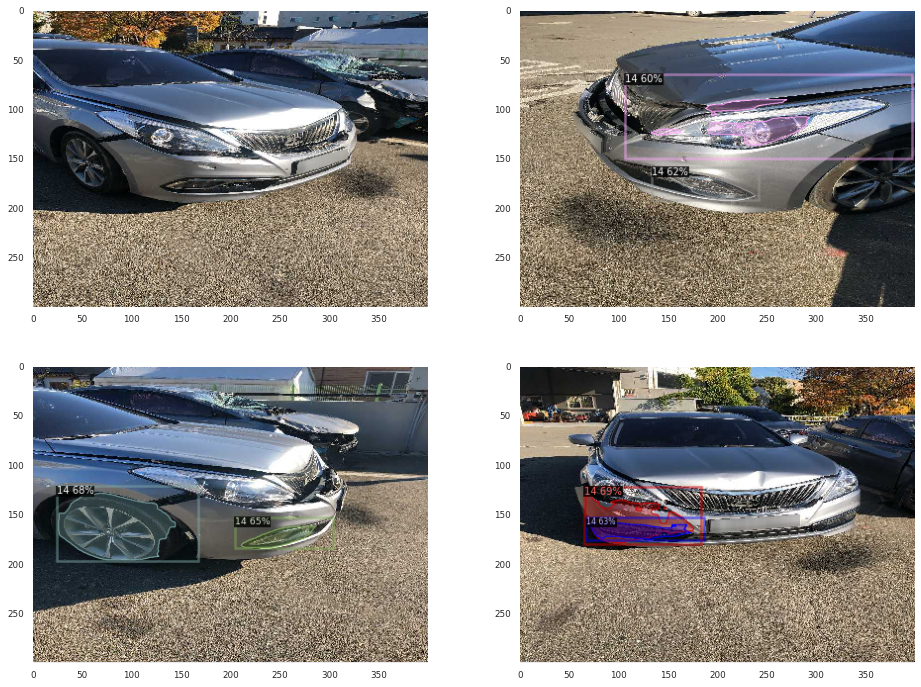

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(16,12))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1]]
i=-1
test_image_names = ["./drive/MyDrive/input/1.jpg","./drive/MyDrive/input/2.jpg","./drive/MyDrive/input/3.jpg","./drive/MyDrive/input/4.jpg"]
for d in test_image_names:
    i=i+1    
    #val_image_name = d["file_name"]
   
    im = io.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    print(outputs["instances"].pred_classes.tolist())
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(16,12))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(val_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [ ]:
!python --version